# Query x Query

This notebook describes a query x query strategy for query-by-humming. A query is matched against previously classified queries and results are sorted by the match scores.

Queries are transcribed as pitch vectors, preprocessed and matched using DTW. Following cells will show and explain every step for the experiment.

## Dataset example

The dataset is comprised of wav files and its transcriptions.

An example of file can be played and its transcription is plotted and its values are shown below.

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.     58.1635 58.1635
 58.1635 57.6617 57.6617 57.174  57.174  57.174  57.174  57.174  57.174
 57.174  57.174  57.174  57.174  57.174  57.6617 57.174  57.174   0.
  0.      0.      0.     59.7627 59.7627 59.7627 59.7627 59.7627  0.
  0.      0.      0.     61.5248 61.5248 61.5248 61.5248 61.5248 61.5248
 61.5248 61.5248 61.5248 61.5248 61.5248 60.9173  0.      0.      0.
 61.5248 61.5248 61.5248 61.5248 61.5248 61.5248 61.5248 61.5248 61.5248
 62.1544 61.5248 61.5248 60.9173  0.      0.     60.3304 60.3304 60.3304
 60.3304 59.7627  0.      0.      0.     57.6617 57.6617 57.6617 57.6617
 57.6617  0.      0.     59.7627 59.7627 59.7627 59.7627  0.      0.
  0.     62.1544 61.5248 61.5248 60.9173 60.9173  0.      0.      0.
 58.1635 57.6617 57.174  57.6617 57.6617 57.174  57.6617 57.6617 57.6617
 57.6617 57.6617 57.6617 57.6617 57.6617 57.174  57.174   0.      0.
  0.   

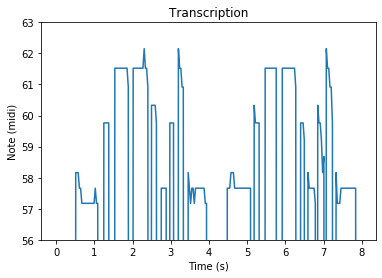

In [7]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import IPython
IPython.display.display(IPython.display.Audio(url='00001.wav'))
with open('00001.pv') as f:
    s = []
    for row in csv.reader(f):
        s.append(float(row[0]))
    s = np.array(s)
    print(s)
    plt.plot(np.arange(len(s))/250*8, s)
    plt.ylim([56, 63])
    plt.title('Transcription')
    plt.xlabel('Time (s)')
    plt.ylabel('Note (midi)')
    print(len(s))

## Mod12 array

First process applied to pitch vectors is applying mod12 to its midi values. 
This creates an octave incensitive version of the pitch vector.


This step is taken to consider that, to our ears, a sound heard with a pitch of `x Hz` will be associated with a sound of `2x Hz`. 

In the cell below, the values of the transformed array are shown and plotted. 

[10.1635 10.1635 10.1635  9.6617  9.6617  9.174   9.174   9.174   9.174
  9.174   9.174   9.174   9.174   9.174   9.174   9.174   9.6617  9.174
  9.174  11.7627 11.7627 11.7627 11.7627 11.7627  1.5248  1.5248  1.5248
  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  0.9173
  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248
  2.1544  1.5248  1.5248  0.9173  0.3304  0.3304  0.3304  0.3304 11.7627
  9.6617  9.6617  9.6617  9.6617  9.6617 11.7627 11.7627 11.7627 11.7627
  2.1544  1.5248  1.5248  0.9173  0.9173 10.1635  9.6617  9.174   9.6617
  9.6617  9.174   9.6617  9.6617  9.6617  9.6617  9.6617  9.6617  9.6617
  9.6617  9.174   9.174   9.6617  9.6617  9.6617 10.1635 10.1635 10.1635
  9.6617  9.6617  9.6617  9.6617  9.6617  9.6617  9.6617  9.6617  9.6617
  9.6617  9.6617  9.6617  9.6617  9.6617  0.3304 11.7627 11.7627 11.7627
 11.7627  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248
  1.5248  1.5248  1.5248  1.5248  1.5248  1.5248  1.5

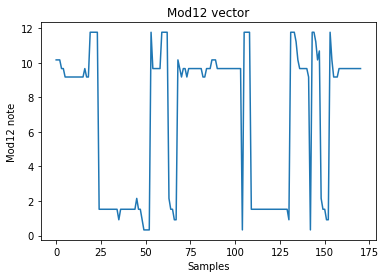

In [8]:
# Note that the 0 values (or silent moments) are removed from the array. 
# They could not be used consistently in the rotation that will happen in one of the next steps.
s = s[s!=0] 
s = np.mod(s, 12)
print(s)
plt.plot(range(len(s)), s)
plt.title('Mod12 vector')
plt.xlabel('Samples')
plt.ylabel('Mod12 note')
plt.show()
# Also note that the time scale will not make sense from this step ahead.
# Sample number is going to be used as the scale.

## Set number of samples

The number of samples from last step is set to 40. Considering that all wav files from our dataset have 8 seconds, a file without silences, will have a sample rate of 5 samples per second after this step.

This is done to reduce processing time for the DTW step. A mean filter is used for avoiding loss of information.

[10.1635  9.6617  9.174   9.174   9.174  11.7627  1.5248  1.5248  0.9173
  1.5248  1.5248  0.9173  0.3304  9.6617 11.7627  1.5248  9.174   9.6617
  9.6617  9.174  10.1635  9.6617  9.6617  9.6617 11.7627  1.5248  1.5248
  1.5248  1.5248  1.5248 11.7627 10.1635  9.6617 11.7627  2.1544 11.7627
  9.174   9.6617  9.6617  9.6617]


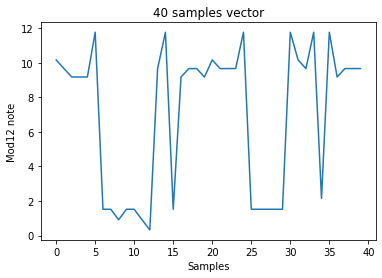

In [9]:
import scipy.ndimage
factor = 40.0/len(s)
s = scipy.ndimage.zoom(s, factor, order=0)
print(s)
plt.plot(range(len(s)), s)
plt.title('40 samples vector')
plt.xlabel('Samples')
plt.ylabel('Mod12 note')
plt.show()

## Dispersion reduction

This step reduces dispersion of mod12 notes, subtracting the mean of differences from nearest integer mod12 note. 

[ 9.63958  9.13778  8.65008  8.65008  8.65008 11.23878  1.00088  1.00088
  0.39338  1.00088  1.00088  0.39338 11.80648  9.13778 11.23878  1.00088
  8.65008  9.13778  9.13778  8.65008  9.63958  9.13778  9.13778  9.13778
 11.23878  1.00088  1.00088  1.00088  1.00088  1.00088 11.23878  9.63958
  9.13778 11.23878  1.63048 11.23878  8.65008  9.13778  9.13778  9.13778]


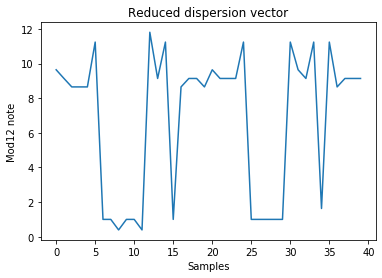

In [10]:
a = 0
for ii in s:
    a += ii-int(ii)
avg = a/len(s) # Mean of difference from nearest integer
s = np.mod(s-avg,12) # Subtract mean of differences, trying to reduce dispersion
print(s)
plt.plot(range(len(s)), s)
plt.title('Reduced dispersion vector')
plt.xlabel('Samples')
plt.ylabel('Mod12 note')
plt.show()

## Tone rotation

12 versions of the vector are created, where each vector has a different reference note. This is done to avoid being unable to match queries where the singers use a different reference.

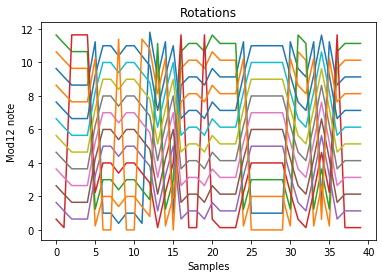

In [11]:
d = []
for i in range(12):
    m = np.mod(s+i,12)
    plt.plot(m)
    d.append(m)
plt.title('Rotations')
plt.xlabel('Samples')
plt.ylabel('Mod12 note')
plt.show()

## Another example

Cells below show the same steps described above for another query. 

This query is going to be used for the DTW step. 

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       46.42     46.1635   48.0442   49.2184   48.9173
 48.0442    0.        0.        0.        0.        0.       49.8368
 49.8368   49.5248   50.4781   49.8368   49.8368   51.4868   51.8366
 51.8366   51.8366   50.8078    0.        0.        0.        0.
  0.        0.        0.        0.        0.       54.0979   51.8366
 51.144    51.4868   51.4868   51.8366   51.8366   52.1935   52.558
 52.558    52.1935   51.4868   51.144     0.        0.        0.
  0.       48.6214   46.9447   47.7627   47.7627   47.7627   46.9447
 47.7627   48.0442   48.3304    0.        0.        0.        0.
  0.       48.0442   47.4857   48.0442   48.3304   48.0442   46.6804
  0.        0.        0.        0.       50.8078   49.8368   49.2184
 51.4868   48.9173   48.0442   49.2184   50.1544   50.807818 51.4868
 51.4868   50.8078    0.        0.        0.        0. 

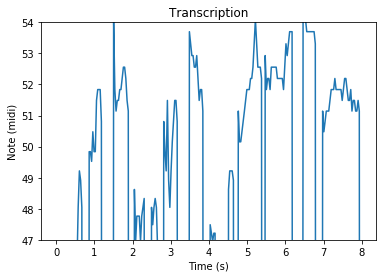

In [12]:
IPython.display.display(IPython.display.Audio(url='00047.wav'))
with open('00047.pv') as f:
    s = []
    for row in csv.reader(f):
        s.append(float(row[0]))
    s = np.array(s)
    print(s)
    plt.plot(np.arange(len(s))/250*8, s)
    plt.ylim([47,54])
    plt.title('Transcription')
    plt.xlabel('Time (s)')
    plt.ylabel('Note (midi)')

[ 9.87770873  0.37500872  0.98250872  3.29430872  5.55560873  2.94450873
  4.01570873  2.60170872 11.22040873 11.78810872 11.78810872  1.29450872
 11.50190872  2.94450873  4.38800873  4.38800873  3.29430872 10.40240872
  0.67610873  2.60170872  2.60170872  3.29430872  4.76860872  4.01570873
  3.29430872  4.01570873  3.65120873  3.65120873  4.38805973  5.15760873
  5.15760873  5.15760873  1.93580872  2.60170872  3.29430872  3.29430872
  3.29430872  2.94450873  2.94450873  2.60170872]


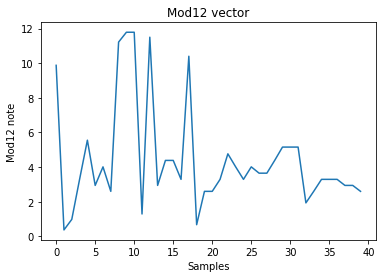

In [13]:
s = s[s!=0]
s = np.mod(s, 12)
factor = 40.0/len(s)
s = scipy.ndimage.zoom(s, factor, order=0)
a = 0
for ii in s:
    a += ii-int(ii)
media = a/len(s) # Media dos residuos
s = np.mod(s-media,12) # Retira residuos para tentar aproximar queries com tons 'muito' proximos
print(s)
plt.plot(range(len(s)), s)
q = s
plt.title('Mod12 vector')
plt.xlabel('Samples')
plt.ylabel('Mod12 note')
plt.show()

## DTW

This step shows the matching algorithm, DTW, creating similarity score for a query and a rotation of a query.

In the figure the accumulated dissimilarity matrix is shown. The minimal score value in the highlighted area is shown with a circle.

We use the metric for dissimilarity `(min(np.mod(u-v,12), np.mod(v-u,12))/6)`. This gives a number between 0 and 1 and consider the circular distance between notes, since note 0 is very close to note 11.

We multiply the accumulated dissimilarity matrix for a pondering matrix that makes every position get a comparable value. 

For the score, we consider a small area around the end of the matrix, covering 25% of each query. The minimal value accumulated up to this area is going to be used as the score.

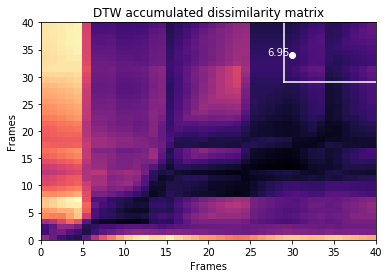

In [16]:
import numpy as np
import librosa.display

X = np.zeros((40,40))
for i in range(40):
    for j in range(40):
        X[i,j] = 1/((max(i,j)+1)/40)
        
fig = plt.figure()
ax = fig.add_subplot(111)
D, wp = librosa.sequence.dtw(q, d[2], subseq=False, backtrack=True, metric=lambda u, v: (min(np.mod(u-v,12), np.mod(v-u,12))/6)) 
E = D*X
librosa.display.specshow(E, x_axis='frames', y_axis='frames')
x, y = np.where(E == np.min(E[-10:,-10:]))
plt.plot(x, y, color='w', marker='o')
plt.plot(np.ones(12)*29, np.arange(12)+29, color='w')
plt.plot(np.arange(12)+29, np.ones(12)*29, color='w')
ax.annotate(round(np.min(E[-10:,-10:]), 2), xy=(x-3,y), textcoords='data', color='w')
plt.title('DTW accumulated dissimilarity matrix')
plt.show()

## Considering rotation

The score for a match has to consider every rotation of target query. Then the minimal value among then is set as the final score between query and pre-classified query.

In [17]:
score_vector = []
for dd in d:
    D = librosa.sequence.dtw(q, dd, subseq=False, backtrack=False, metric=lambda u, v: (min(np.mod(u-v,12), np.mod(v-u,12))/6))
    E = D*X
    score = np.min(E[-10:,-10:])
    score_vector.append(score)
print('Score of every rotation:', np.round(score_vector,2))
print('Minimal score', round(min(score_vector),2))

Score of every rotation: [15.32 10.11  6.95  5.62  6.1   8.16 10.75 13.15 16.   16.99 18.07 18.1 ]
Minimal score 5.62


## Another example

Following cells show another example of the whole process. In this example, however, the query and the target are classified as the same melody.

[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.     47.2131 46.6804 46.42   46.6804 47.2131 47.4857 47.7627
 48.0442 47.7627 47.7627 47.4857 47.2131 47.4857 47.4857 47.4857 47.7627
 48.0442 47.7627 47.7627  0.      0.      0.     50.1544 50.1544 50.478
 50.478  50.8078  0.      0.      0.     52.1935 51.4868 51.4868 51.4868
 51.4868 51.4868 51.4868 51.4868 51.8366 52.1935  0.      0.      0.
  0.      0.     51.8366 51.4868 51.4868 51.4868 51.4868 51.8366 51.8366
 51.8366 51.8366 51.8366 51.8366 51.8366  0.      0.      0.     49.2184
 48.9173 49.2184 49.2184  0.      0.      0.     48.3304 47.7627 47.2131
 47.2131  0.      0.      0.      0.     49.2184 49.2184 49.2184  0.
  0.      0.      0.     51.4868 51.4868 51.4868 51.8366 51.144   0.
  0.      0.     47.4857 47.2131 47.2131 47.2131 47.2131 47.4857 47.7627
 47.7627 47.7627  0.      0.      0.      0.      0.     44.238  44.238
  0.      0.      0.      0.      0.      0.      0.      0.      0.


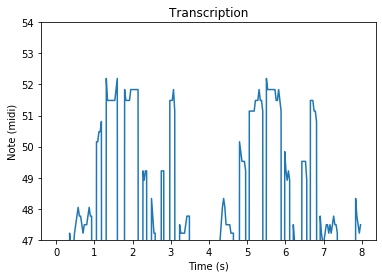

In [18]:
IPython.display.display(IPython.display.Audio(url='00001-2.wav'))
with open('00001-2.pv') as f:
    s = []
    for row in csv.reader(f):
        s.append(float(row[0]))
    s = np.array(s)
    print(s)
    plt.plot(np.arange(len(s))/250*8, s)
    plt.ylim([47,54])
    plt.title('Transcription')
    plt.xlabel('Time (s)')
    plt.ylabel('Note (midi)')

[10.7145675 10.7145675 11.2641675 10.9871675 11.5456675  1.6558675
  3.6949675  2.9882675  3.6949675  2.9882675  3.3380675  3.3380675
  0.7198675 10.7145675  2.9882675  2.6454675 10.7145675 11.2641675
 10.4461675 10.4461675 10.9871675 10.7145675  1.3382675  0.7198675
  2.6454675  2.9882675  2.6454675  3.3380675  3.3380675  2.9882675
  0.4187675 10.4461675  1.0262675  2.9882675  2.3092675 10.4461675
 10.7145675 11.2641675 11.8318675 10.9871675]


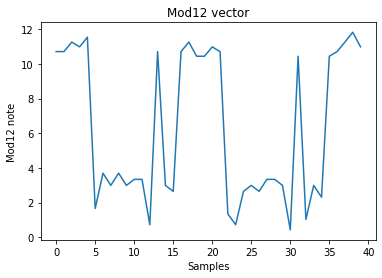

In [19]:
s = s[s!=0]
s = np.mod(s, 12)
factor = 40.0/len(s)
s = scipy.ndimage.zoom(s, factor, order=0)
a = 0
for ii in s:
    a += ii-int(ii)
media = a/len(s) # Media dos residuos
s = np.mod(s-media,12) # Retira residuos para tentar aproximar queries com tons 'muito' proximos
print(s)
plt.plot(range(len(s)), s)
q = s
plt.title('Mod12 vector')
plt.xlabel('Samples')
plt.ylabel('Mod12 note')
plt.show()

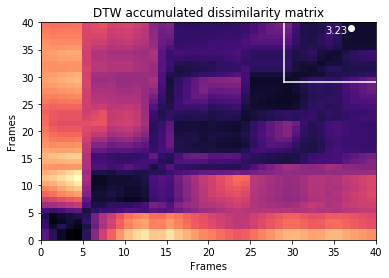

In [20]:
import numpy as np
import librosa.display

X = np.zeros((40,40))
for i in range(40):
    for j in range(40):
        X[i,j] = 1/((max(i,j)+1)/40)
        
fig = plt.figure()
ax = fig.add_subplot(111)
D, wp = librosa.sequence.dtw(q, d[2], subseq=False, backtrack=True, metric=lambda u, v: (min(np.mod(u-v,12), np.mod(v-u,12))/6)) 
E = D*X
librosa.display.specshow(E, x_axis='frames', y_axis='frames')
x, y = np.where(E == np.min(E[-10:,-10:]))
plt.plot(x, y, color='w', marker='o')
plt.plot(np.ones(12)*29, np.arange(12)+29, color='w')
plt.plot(np.arange(12)+29, np.ones(12)*29, color='w')
ax.annotate(round(np.min(E[-10:,-10:]), 2), xy=(x-3,y-1), textcoords='data', color='w')
plt.title('DTW accumulated dissimilarity matrix')
plt.show()

In [21]:
import librosa

score_vector = []
for dd in d:
    D = librosa.sequence.dtw(q, dd, subseq=False, backtrack=False, metric=lambda u, v: (min(np.mod(u-v,12), np.mod(v-u,12))/6))
    E = D*X
    score = np.min(E[-10:,-10:])
    score_vector.append(score)
print('Score of every rotation:', np.round(score_vector,2))
print('Minimal score', round(min(score_vector),2))

Score of every rotation: [10.87  6.19  3.23  5.37  9.45 14.41 16.4  19.42 21.04 19.5  18.55 16.28]
Minimal score 3.23


## Ranking

This cell uses the pre-calculated `scores.csv` to show the top 5 results sorted by dtw scores following the process described above. In this example, only one line of the file is used, thus what is seen is the result of comparing one query against the whole dataset.

In [56]:
import csv
import numpy as np
from matplotlib import pyplot as plt

with open('/app/code/qxq/scores.csv', newline='') as o:
    reader = csv.reader(o, delimiter=' ')
    db_files = []
    query_files = []
    file_list = next(reader)
    part = {}
    for filename in file_list[1:-1]:
        db_files.append(filename)
    row = next(reader)
    all_values = []
    for i, db_file in zip(part.get(row[0], []) + row[1:-1], db_files):
        if not db_file in part:
            part[db_file] = []
        part[db_file].append(i)
        all_values.append(float(i))
    all_values = np.array(all_values)
    db_files = np.array(db_files)
    index_sorted = np.argsort(all_values)
    print('Top 5 results')
    print('Class', 'Score', sep='\t')
    for i in zip(db_files[index_sorted][1:6], all_values[index_sorted][1:6]):
        print(int(i[0][-11:-9]), round(i[1], 2), sep='\t')

Top 5 results
Class	Score
13	0.34
13	0.5
13	0.51
13	0.54
13	0.54


## Ranking method: class

This example ranks results using the mean score of a class from the dataset. Thus, the query will be matched using the processes described above against the whole dataset. Then scores are grouped by the class of the melody they belong. The mean of the class is taken and the list of results will be the sorted list of means for all the classes.

In the cell we show the result of applying this method to 5 queries.

In [61]:
import csv
import numpy as np

with open('/app/code/qxq/scores.csv', newline='') as o:
    reader = csv.reader(o, delimiter=' ')
    db_files = []
    query_files = []
    file_list = next(reader)
    part = {}
    for filename in file_list[1:-1]:
        db_files.append(filename)
    print('Query file                            ', 'Top 5', sep='\t')
    for _ in range(5):
        row = next(reader)
        all_values = []
        classes = [[] for i in range(50)]
        for i, db_file in zip(part.get(row[0], []) + row[1:-1], db_files):
            if not db_file in part:
                part[db_file] = []
            part[db_file].append(i)
            if float(i) > 0:
                classes[(int(db_file.split('/000')[1][:2]))].append(float(i))
            all_values.append(float(i))

        all_values = np.array(all_values)
        db_files = np.array(db_files)
        index_sorted = np.argsort(all_values)
        means = [np.mean(sorted(i)[:]) for i in classes]
        means = np.array(means)
        ranked_classes = np.argsort(means)
        
        print(row[0][13:], ranked_classes[:5], sep='\t')a

Query file                            	Top 5
year2007/person00007/00013.pv.mod12	[13 38  8 21 14]
year2007/person00007/00035.pv.mod12	[35 19 48 34 30]
year2007/person00007/00024.pv.mod12	[24 11 42 31 28]
year2007/person00007/00017.pv.mod12	[20 42  4 43 31]
year2007/person00007/00019.pv.mod12	[19 35 27  5 32]


## Evaluation

This cell shows MRR and recall for 5 methods of ranking creation over the complete dataset.

2 of the methods are shown in cells above, the other methods are combinations of those 2 methods. The inter method filters the sorted score list with top 3 classes from the class method. The mult method multiply scores of query by the score of its class. And the mult2 multiply by the square of the score of the class.

In [78]:
import csv
import numpy as np

query = []
top = []
classes_rank = []
inter = []
mult = []
mult2 = []
with open('/app/code/qxq/scores.csv', newline='') as o:
    reader = csv.reader(o, delimiter=' ')
    db_files = []
    query_files = []
    file_list = next(reader)
    part = {}
    top = []
    errors = 0
    for filename in file_list[1:-1]:
        db_files.append(filename)
    rrs = {}
    for row in reader:
        correct_values = []
        all_values = []
        incorrect_values = []
        itsy = []
        classes = [[] for i in range(50)]
        query_files.append(row[0])
        for i, db_file in zip(part.get(row[0], []) + row[1:-1], db_files):
            if not db_file in part:
                part[db_file] = []
            part[db_file].append(i)
            if float(i) > 0:
                classes[(int(db_file.split('/000')[1][:2]))].append(float(i))
            all_values.append(float(i))
        all_values = np.array(all_values)
        db_files = np.array(db_files)
        index_sorted = np.argsort(all_values)
        means = [np.mean(sorted(i)[:]) for i in classes]
        means = np.array(means)
        ranked_classes = np.argsort(means)

        mix_weights = []
        for i, val in enumerate(db_files):
            val = int(val[-11:-9])
            mix_weights.append(all_values[i]*means[val]*means[val])

        mix_weights = np.array(mix_weights)
        index = np.argsort(mix_weights)

        mix_weights = []
        for i, val in enumerate(db_files):
            val = int(val[-11:-9])
            mix_weights.append(all_values[i]*means[val])

        mix_weights = np.array(mix_weights)
        index2 = np.argsort(mix_weights)

        mixed_list = []
        for i in db_files[index_sorted][1:]:
            val = int(i[-11:-9])
            if val in ranked_classes[:2] and len(mixed_list)<5:
                mixed_list.append(val)

        query = int(row[0][-11:-9])
        rr = 0
        if not rrs.get(query):
            rrs[query] = []
        for i in range(5):
            if query == int(db_files[index_sorted][i+1][-11:-9]):
                rr = 1/(i+1)
                break
        rrs[query].append(rr)
        top.append(rr)

        rr = 0
        for i in range(5):
            if query == ranked_classes[i]:
                rr = 1/(i+1)
                break
        classes_rank.append(rr)

        rr = 0
        for i in range(len(mixed_list)):
            if query == mixed_list[i]:
                rr = 1/(i+1)
                break
        inter.append(rr)

        rr = 0
        for i in range(5):
            if query == int(db_files[index][i+1][-11:-9]):
                rr = 1/(i+1)
                break
        mult.append(rr)

        rr = 0
        for i in range(5):
            if query == int(db_files[index2][i+1][-11:-9]):
                rr = 1/(i+1)
                break
        mult2.append(rr)
        
        rr = 0
        query = row[0][-11:-9]

    print("Method", "Top", "Class", "Inter", "Mult", "Mult2", sep="\t")
    print("MRR", "%.2f" % np.mean(top), "%.2f" % np.mean(classes_rank), "%.2f" % np.mean(inter), "%.2f" % np.mean(mult), "%.2f" % np.mean(mult2), sep='\t') 
    print("Recall", "%.2f" % (100*(len(top)-np.count_nonzero(top))/len(top)), 
          "%.2f" % (100*(len(classes_rank)-np.count_nonzero(classes_rank))/len(classes_rank)), 
          "%.2f" % (100*(len(inter)-np.count_nonzero(inter))/len(inter)), 
          "%.2f" % (100*(len(mult)-np.count_nonzero(mult))/len(mult)), 
          "%.2f" % (100*(len(mult2)-np.count_nonzero(mult2))/len(mult2)), sep='\t')    

Method	Top	Class	Inter	Mult	Mult2
MRR	0.93	0.91	0.91	0.93	0.94
Recall	3.30	3.30	7.61	5.74	4.43


## Evaluation by class

In this cell we show MRR and recall of each individual class

In [75]:
print("%.2f" % np.mean(top), errors, sep='\t')
print("Individual")
print("MRR", "N", "id", 'Recall', sep='\t')
for i in range(1,49):
    print("%.2f" % np.mean(rrs[i]), len(rrs[i]), i, "%.2f" % (100*(np.count_nonzero(rrs[i]))/len(rrs[i])), sep='\t')    

Geral
MRR	erros
0.93	0
Individual
MRR	N	id
0.87	19	1	94.74
0.71	14	2	78.57
0.57	11	3	63.64
0.72	15	4	80.00
0.80	15	5	80.00
0.48	12	6	66.67
0.86	15	7	93.33
0.48	15	8	66.67
0.58	12	9	75.00
0.92	19	10	94.74
0.89	96	11	91.67
0.97	153	12	98.69
0.97	161	13	97.52
0.89	159	14	97.48
0.79	27	15	85.19
0.98	160	16	98.75
0.88	152	17	97.37
0.98	164	18	98.78
0.96	158	19	98.73
0.97	170	20	98.82
0.93	66	21	100.00
0.94	172	22	98.26
0.92	62	23	96.77
0.92	121	24	94.21
0.93	123	25	98.37
0.91	52	26	94.23
0.96	85	27	97.65
0.95	91	28	96.70
0.97	149	29	99.33
0.98	144	30	99.31
0.92	141	31	96.45
0.97	137	32	98.54
0.90	116	33	97.41
0.97	137	34	97.81
0.95	149	35	97.32
0.85	43	36	97.67
0.90	66	37	95.45
0.93	114	38	95.61
0.93	147	39	96.60
0.93	71	40	92.96
0.99	126	41	100.00
0.93	92	42	94.57
0.92	123	43	98.37
0.89	80	44	92.50
0.95	99	45	96.97
0.92	92	46	95.65
0.89	29	47	93.10
0.94	53	48	96.23
